<a href="https://colab.research.google.com/github/Lindronics/honours_project/blob/master/notebooks/autoencoder/RGB_FIR_Autoencoder_Animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-gpu==2.1
!pip install -q grpcio==1.24.3

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 450kB 49.7MB/s 
     |████████████████████████████████| 3.8MB 50.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
     |████████████████████████████████| 2.2MB 8.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.


In [2]:
%%time
!rm -rf dataset.zip images_augmented __MACOSX
!wget --no-check-certificate -O dataset.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228178&authkey=AN-eBemLKMn1Ef4"
!unzip -q dataset.zip

--2020-02-20 10:51:24--  https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228178&authkey=AN-eBemLKMn1Ef4
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://hl2tzg.am.files.1drv.com/y4mSOKmEL7puGKieVbi02PiAZq8BQVISXrlCrFutTkQgDa2JOqXagHQ5ZwUSlN5eaZuPKrrSFdYS6sm4X0wKzSZ0XaZDhZI3kiolKsqmMzW4ILOLzFYWvQ6GOfngytHHdelgiSV4emA4E2SgpOYjGs4SUT_ZlL0Lhm-xvY1qG8cxzB-68LUFnC5tyxmcCSepqQypKx6kWF9YNq3wzm-LtHZuA/images_augmented.zip?download&psid=1 [following]
--2020-02-20 10:51:34--  https://hl2tzg.am.files.1drv.com/y4mSOKmEL7puGKieVbi02PiAZq8BQVISXrlCrFutTkQgDa2JOqXagHQ5ZwUSlN5eaZuPKrrSFdYS6sm4X0wKzSZ0XaZDhZI3kiolKsqmMzW4ILOLzFYWvQ6GOfngytHHdelgiSV4emA4E2SgpOYjGs4SUT_ZlL0Lhm-xvY1qG8cxzB-68LUFnC5tyxmcCSepqQypKx6kWF9YNq3wzm-LtHZuA/images_augmented.zip?download&psid=1
Resolving hl2tzg.am.files.1drv.com (hl2tzg

In [0]:
import tensorflow as tf
from tensorflow import keras as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import cv2
from sklearn.model_selection import train_test_split
from datetime import datetime
import os
from tqdm import tqdm

In [4]:
from os import listdir
from os.path import isdir, join

configurations = {
    "medium": lambda fname: fname.split("_")[0] not in ["human", "evil-chicken", "ferret"],
    "cat": lambda fname: fname.split("_")[0] == "cat",
    "goose": lambda fname: fname.split("_")[0] == "goose",
    "pony": lambda fname: fname.split("_")[0] == "pony",
}

def generate_metadata(config, root="images"):
    """ Generates labels to be read by model data loader """

    classes = [c for c in listdir(root) if isdir(join(root, c))]
    samples = {c: 0 for c in classes}
    
    with open(f"labels_{config}.txt", "w") as f:
        for c in classes:
            batches = [b for b in listdir(join(root, c)) if isdir(join(root, c, b)) and configurations[config](b)]
            
            for b in batches:
                lwir_images = [i for i in listdir(join(root, c, b, "lwir")) if i.endswith(".png")]
                rgb_images = [i for i in lwir_images]

                lwir_paths = [join(root, c, b, "lwir", i) for i in lwir_images]
                rgb_paths = [join(root, c, b, "rgb", i) for i in rgb_images]

                for lwir_path, rgb_path in zip(lwir_paths, rgb_paths):
                    f.write(" ".join([rgb_path, lwir_path, c]) + "\n")
                    samples[c] += 1

    print("Dataset composition:")
    sum_ = 0
    for c, s in samples.items():
        sum_ += s
        print(f" - {c}: \t{s}")
    print(f"{sum_} items total.")

generate_metadata("pony", root="images_augmented")

Dataset composition:
 - rabbit: 	0
 - pig: 	0
 - cat: 	0
 - chicken: 	0
 - pretty-chicken: 	0
 - sheep: 	0
 - peacock: 	0
 - ugly-duck: 	0
 - goose: 	0
 - alpaca: 	0
 - pony: 	336
336 items total.


In [0]:
transformation = np.array([
    [1.202290, -0.026808, -50.528589],
    [0.017762, 1.203090, -73.950204],
])

input_shape = (320, 240, 1)

class Dataset(K.utils.Sequence):

    def __init__(self, metadata, res=(240, 320), register=True, batch_size=16):

        self.res = res
        self.register = register
        self.batch_size = batch_size

        self.samples = list()

        with open(metadata, "r") as f:
            for line in f:
                line = line.split()
                self.samples.append(tuple(line[:2]))

        # self.idx = 0

    def __len__(self):
        return len(self.samples) // self.batch_size
    
    def __iter__(self):
        return self

    def load(self, path, register=False):
        img = cv2.imread(path) / 255
        if register:
            img = cv2.resize(img, (480, 640))
            img = cv2.warpAffine(img, transformation, (480, 640))
        img = cv2.resize(img, self.res)
        return img

    def __getitem__(self, idx):
        if idx < self.__len__():
            X = []
            y = []
            for i in range(self.batch_size):
                rgb_path, lwir_path = self.samples[idx * self.batch_size + i]
                rgb = self.load(rgb_path, register=True)
                rgb = np.mean(rgb, -1)[..., None]

                lwir = self.load(lwir_path, register=False)
                lwir = np.mean(lwir, -1)[..., None]

                X.append(rgb)
                y.append(lwir)

            # self.idx += self.batch_size
            return np.array(X), np.array(y)
        else:
            self.idx = 0
            raise StopIteration

    def num_classes(self):
        return len(self.classes)

    def shape(self):
        return self.res[::-1] + tuple([(3 if self.rgb_only else 4)])

data = Dataset("labels_pony.txt", register=False)

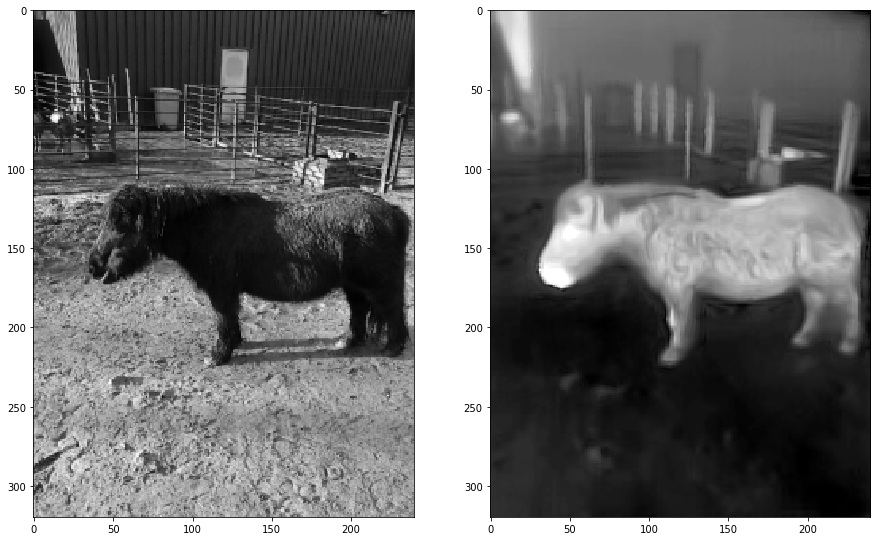

In [6]:
X, y = data[8]

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
# print(X_train.shape)
X_train = X
y_train = y

i = 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(X[i, ..., 0], cmap="gray")
ax2.imshow(y_train[i, ..., 0], cmap="gray")

In [0]:
model = K.Sequential()

model.add(K.layers.Input(shape=input_shape))

# Encoder
model.add(K.layers.Conv2D(8, kernel_size=(5, 5), strides=(1, 1), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2D(16, kernel_size=(7, 7), strides=(1, 1), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2D(32, kernel_size=(7, 7), strides=(1, 1), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2D(64, kernel_size=(7, 7), strides=(1, 1), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

# model.add(K.layers.Dropout(0.4))

# Decoder
model.add(K.layers.Conv2DTranspose(32, kernel_size=(7, 7), strides=(2, 2), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2DTranspose(16, kernel_size=(7, 7), strides=(2, 2), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2DTranspose(8, kernel_size=(7, 7), strides=(2, 2), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding="same"))
model.add(K.layers.LeakyReLU())

# model.add(K.layers.Lambda(lambda x: x[:, 2:-1, 2:-1, :]))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy', 'mean_squared_error'])
# model.summary()

In [0]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [12]:
%%time
# !rm -rf logs
log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

# model.fit(X_train, y_train, batch_size=4, epochs=150, callbacks=[tensorboard_callback], verbose=1, validation_data=(X_test, y_test))

model.fit_generator(data, epochs=100, callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
Train for 21 steps
Epoch 1/100
21/21 [==============================] - 11s 517ms/step - loss: 0.1000 - accuracy: 1.5179e-04 - mean_squared_error: 0.1000
Epoch 2/100
21/21 [==============================] - 10s 488ms/step - loss: 0.0521 - accuracy: 4.8906e-04 - mean_squared_error: 0.0521
Epoch 3/100
21/21 [==============================] - 10s 485ms/step - loss: 0.0434 - accuracy: 5.4908e-04 - mean_squared_error: 0.0434
Epoch 4/100
21/21 [==============================] - 10s 482ms/step - loss: 0.0386 - accuracy: 5.8156e-04 - mean_squared_error: 0.0386
Epoch 5/100
21/21 [==============================] - 10s 488ms/step - loss: 0.0361 - accuracy: 6.6895e-04 - mean_squared_error: 0.0361
Epoch 6/100
21/21 [==============================] - 10s 485ms/step - loss: 0.0346 - accuracy: 7.1153e-04 - mean_squared_error: 0.0346
Epoch 7/100
21/21 [==============================] - 10s 485ms/step - loss: 0.0324 - accuracy: 7.5219e-04 - mean_squared_error: 0.0324
Epoch 8/100

In [0]:
model.save_weights("weights")

In [0]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

6


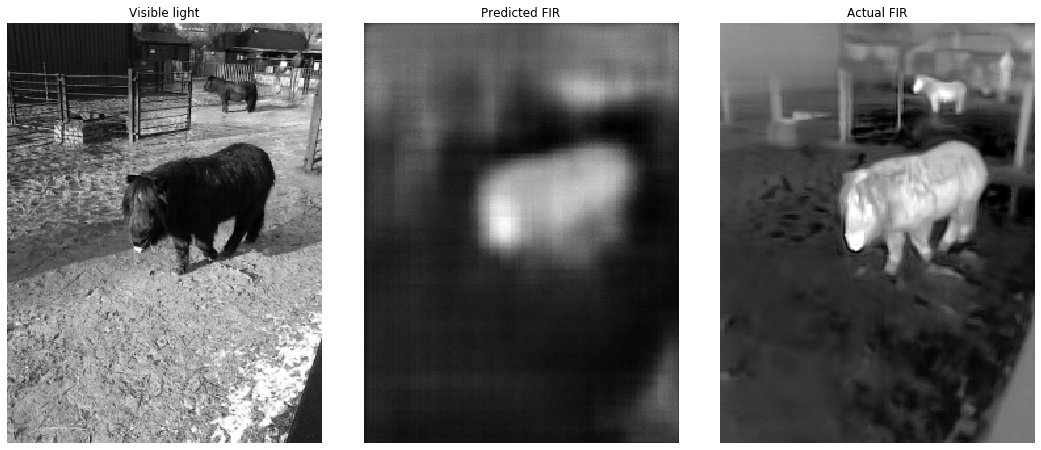

In [9]:
# i = np.random.randint(0, X_test.shape[0] - 1)
i = np.random.randint(0, X_train.shape[0] - 1)
# i = 60
print(i)

test_image = X_train[i]
ref_image = y_train[i]
# test_image = X_test[i]
# ref_image = y_test[i]

predicted_image = model.predict(test_image[None, ...])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
fig.tight_layout()
ax1.imshow(test_image[..., 0], cmap="gray")
ax1.set_title("Visible light")
ax1.axis("off")
ax2.imshow(predicted_image[0, ..., 0], cmap="gray")
ax2.set_title("Predicted FIR")
ax2.axis("off")
ax3.imshow(ref_image[..., 0], cmap="gray")
ax3.set_title("Actual FIR")
ax3.axis("off")
pass

In [0]:
# i = np.random.randint(0, X_test.shape[0] - 1)
# i = np.random.randint(0, X_train.shape[0] - 1)
i = 60
print(i)

# test_image = X_train[i]
# ref_image = y_train[i]
test_image = X_test[i]
ref_image = y_test[i]

predicted_image = model.predict(test_image[None, ...])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
fig.tight_layout()
ax1.imshow(test_image[..., 0], cmap="gray")
ax1.set_title("Visible light")
ax1.axis("off")
ax2.imshow(predicted_image[0, ..., 0], cmap="gray")
ax2.set_title("Predicted FIR")
ax2.axis("off")
ax3.imshow(ref_image[..., 0], cmap="gray")
ax3.set_title("Actual FIR")
ax3.axis("off")
pass

60


IndexError: ignored

--2020-02-20 11:41:48--  https://upload.wikimedia.org/wikipedia/commons/2/20/Sandwick_Shetland_Pony.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4908110 (4.7M) [image/jpeg]
Saving to: ‘custom.jpg’

custom.jpg          100%[===================>]   4.68M  27.5MB/s    in 0.2s    

2020-02-20 11:41:48 (27.5 MB/s) - ‘custom.jpg’ saved [4908110/4908110]

--2020-02-20 11:41:50--  https://upload.wikimedia.org/wikipedia/commons/0/05/Shetland_ponies_at_Sandwick.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4653405 (4.4M) [image/jpeg]
Saving to: ‘custom_2.jpg’

custom_2.jpg        100%[===================

Text(0.5, 1.0, 'Predicted FIR')

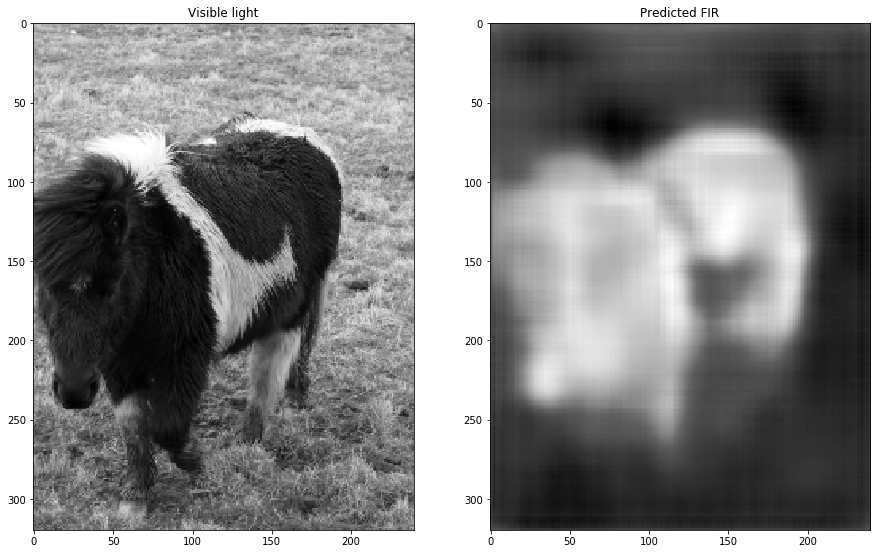

In [15]:
# Custom image
!wget -O custom.jpg https://upload.wikimedia.org/wikipedia/commons/2/20/Sandwick_Shetland_Pony.jpg
!wget -O custom_2.jpg https://upload.wikimedia.org/wikipedia/commons/0/05/Shetland_ponies_at_Sandwick.jpg

transfer_image = cv2.imread("/content/custom_2.jpg") / 255
transfer_image = np.mean(transfer_image, axis=-1)

# Crop
ti_width = transfer_image.shape[1]
transfer_image = transfer_image[:, int(0.2*ti_width):int(0.8*ti_width), ...]

transfer_image = cv2.GaussianBlur(transfer_image, (7, 7), sigmaX=3)
transfer_image = cv2.resize(transfer_image, (input_shape[1], input_shape[0]))[..., None]

predicted_transfer_image = model.predict(transfer_image[None, ...])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(transfer_image[..., 0], cmap="gray")
ax1.set_title("Visible light")
ax2.imshow(predicted_transfer_image[0, ..., 0], cmap="gray")
ax2.set_title("Predicted FIR")

56


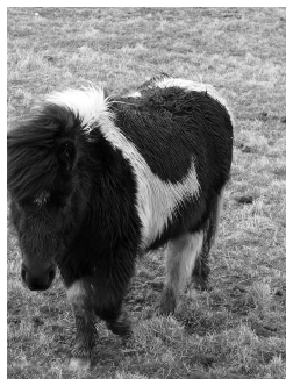

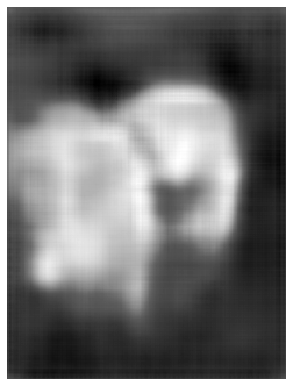

In [16]:
# Generate images for dissertation

i = 56
print(i)

# test_image = X_test[i]
test_image = transfer_image
# ref_image = y_test[i]

predicted_image = model.predict(test_image[None, ...])


plt.figure(figsize=(5,10))
plt.imshow(test_image[..., 0], cmap="gray")
plt.axis("off")

plt.figure(figsize=(5,10))
plt.imshow(predicted_image[0, ..., 0], cmap="gray")
plt.axis("off")

# plt.figure(figsize=(5,10))
# plt.imshow(ref_image[..., 0], cmap="gray")
# plt.axis("off")
pass

In [0]:
K.utils.plot_model(model, to_file='model.png')